# Import packages

In [1]:
import numpy as np
import altair as alt
import pandas as pd
import geopandas as gpd
from datetime import timedelta
from scipy import stats
import statsmodels.formula.api as sm
from matplotlib import pyplot as plt
import seaborn as sns

alt.data_transformers.disable_max_rows()

from helper_functions import open_delays


# Notebook settings

In [2]:
DELAYS_FILEPATH = r'Intermediates\\delays_assigned.csv'

# Load data

Amount of delay values: 3_802_649


,line_name,trip_id,shape_id,stop,sched_arrival_time,previous_stop,next_stop,real_arrival_time,delay,timestep
0,BLUE,3121350_18154_2019-09-14,46,G05,2019-09-14 06:54:00,NaN,G04,2019-09-14 06:46:04,-476.0,6.0
1,BLUE,3121350_18154_2019-09-14,46,G04,2019-09-14 06:57:00,G05,G03,2019-09-14 06:56:12,-48.0,6.0
2,GREEN,3120258_18154_2019-09-14,117,F11,2019-09-14 07:00:00,NaN,F10,2019-09-14 06:45:42,-858.0,7.0


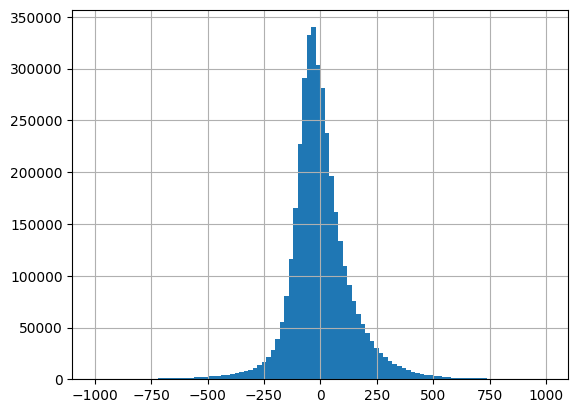

In [3]:
delays = open_delays(DELAYS_FILEPATH)

delays[(delays['delay'] > -1000) & (delays['delay'] < 1000)]['delay'].hist(bins=100)

delays.head(3)

# Finding Inplace function

## Find related values

In [4]:
# 1. Find related values between stops of same trip
delays_sorted = delays.sort_values(by=['trip_id', 'sched_arrival_time']).copy()

stop_values = delays_sorted['stop'].values
delay_values = delays_sorted['delay'].values
trip_ids = delays_sorted['trip_id'].values
arrival_times = delays_sorted['sched_arrival_time'].values
real_arrivals = delays_sorted['real_arrival_time'].values

related_inplace = pd.DataFrame({'line': delays_sorted['line_name'].values,
                               'stop': stop_values,
                               'prev_stop': [stop_values[-1], *stop_values[:-1]],
                               'next_stop': [*stop_values[1:], stop_values[0]],
                               'delay': delay_values,

                               'sched_arrival': arrival_times,
                               'real_arrival': real_arrivals,

                               'trip_id': trip_ids,
                               'prev_trip_id': [trip_ids[-1], *trip_ids[:-1]],
                               'next_trip_id': [*trip_ids[1:], trip_ids[0]]})

print(f"Total: {len(related_inplace):_}")
related_inplace = related_inplace[(related_inplace['trip_id'] == related_inplace['prev_trip_id']) | (related_inplace['trip_id'] == related_inplace['next_trip_id'])]
related_inplace.loc[related_inplace['trip_id'] != related_inplace['prev_trip_id'], ['prev_stop', 'real_arrival_prev_stop']] = None
related_inplace = related_inplace.drop(columns=['trip_id', 'next_trip_id', 'prev_trip_id'])

print(f"Filtered to only viable: {len(related_inplace):_}")
related_inplace.head(3)

Total: 3_802_649
Filtered to only viable: 3_802_596


,line,stop,prev_stop,next_stop,delay,sched_arrival,real_arrival,real_arrival_prev_stop
0,SILVER,G05,None,G04,-569.0,2019-10-14 13:08:00,2019-10-14 12:58:31,None
1,SILVER,G04,G05,G03,-88.0,2019-10-14 13:11:00,2019-10-14 13:09:32,NaN
2,SILVER,G03,G04,G02,-106.0,2019-10-14 13:14:00,2019-10-14 13:12:14,NaN


In [5]:
# 2. Find related values for stops at same station
related_inplace = related_inplace.sort_values(by=['sched_arrival']).copy()
station_split = {trip_key: data for trip_key, data in related_inplace.groupby(['stop', 'next_stop'])}

updated_dfs = []
for key_pair, station_stops in station_split.items():

    station_stops['delay_ptss'] = [None, *station_stops['delay'][:-1]]
    station_stops['real_arrival_prev_train'] = [None, *station_stops['real_arrival'].values[:-1]]
    station_stops['sched_arrival_prev_train'] = [None, *station_stops['sched_arrival'].values[:-1]]

    updated_dfs.append(station_stops)

related_inplace = pd.concat(updated_dfs)
print(len(related_inplace))
related_inplace.head(3)


3802596


C:\Users\lange\AppData\Local\Temp\ipykernel_10384\37588251.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  related_inplace = pd.concat(updated_dfs)
C:\Users\lange\AppData\Local\Temp\ipykernel_10384\37588251.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  related_inplace = pd.concat(updated_dfs)
C:\Users\lange\AppData\Local\Temp\ipykernel_10384\37588251.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this wil

,line,stop,prev_stop,next_stop,delay,sched_arrival,real_arrival,real_arrival_prev_stop,delay_ptss,real_arrival_prev_train,sched_arrival_prev_train
1618603,RED,A01/C01,B01/F01,A02,58.0,2019-09-14 07:31:00,2019-09-14 07:31:58,NaN,NaN,NaT,NaT
1618623,RED,A01/C01,B01/F01,A02,6.0,2019-09-14 07:42:00,2019-09-14 07:42:06,NaN,58.0,2019-09-14 07:31:58,2019-09-14 07:31:00
1618643,RED,A01/C01,B01/F01,A02,-54.0,2019-09-14 07:50:00,2019-09-14 07:49:06,NaN,6.0,2019-09-14 07:42:06,2019-09-14 07:42:00


## Plot total

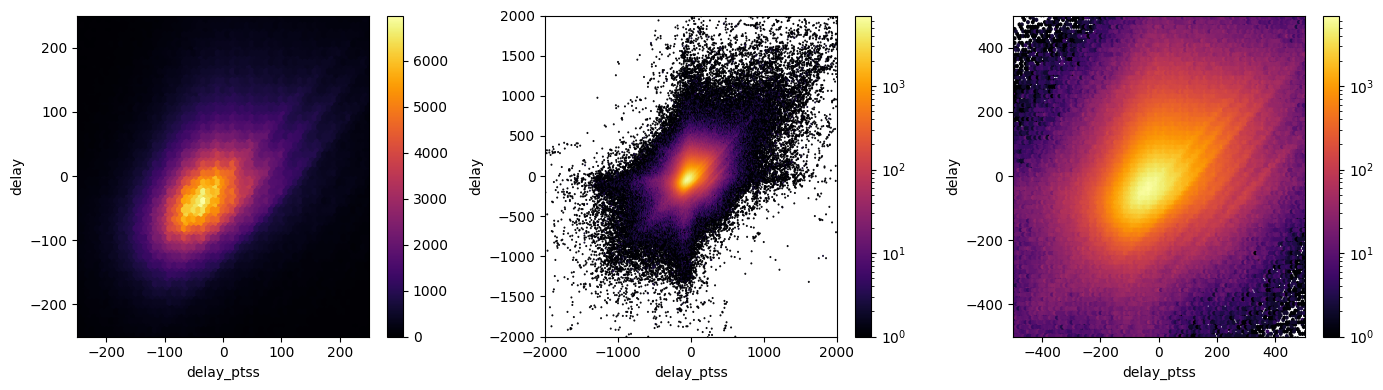

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))

related_inplace.plot(x='delay_ptss', y='delay', kind='hexbin', cmap='inferno', gridsize=1000, ax=ax1)
related_inplace.plot(x='delay_ptss', y='delay', kind='hexbin', cmap='inferno', bins='log', gridsize=1000, ax=ax2)
related_inplace.plot(x='delay_ptss', y='delay', kind='hexbin', cmap='inferno', bins='log', gridsize=1000, ax=ax3)


ax1.set_xlim(-250, 250)
ax1.set_ylim(-250, 250)

ax2.set_xlim(-2000, 2000)
ax2.set_ylim(-2000, 2000)


ax3.set_xlim(-500, 500)
ax3.set_ylim(-500, 500)
# legend = ax.get_legend()
# ax.get_legend().set_visible(False)
# ax1.set_title("Delay vs Previous Stop Delay hexbin/2d hist plot")
# plt.show()
plt.tight_layout()
fig.savefig(r'Codebase figures\\Inplace_data_total.png', dpi=300)

## Find filters and perform on single connection

In [7]:
single_connection = related_inplace[(related_inplace['stop'] == 'D08') & (related_inplace['next_stop'] == 'D07')].copy()

filter_1 = single_connection[(single_connection['real_arrival_prev_train'] >= single_connection['sched_arrival'])].copy()

filter_2 = filter_1[filter_1['real_arrival'] > filter_1['real_arrival_prev_train']].copy()

# Include normalize if we want to fit inplace as well
normalized = filter_2.copy()
normalized['delay_diff'] = normalized['delay'] - normalized['delay_ptss']
normalized['sched_time_diff'] = (normalized['sched_arrival'] - normalized['sched_arrival_prev_train']).dt.total_seconds()
normalized['delay_diff_2'] = normalized['delay'] - (normalized['delay_ptss'] - normalized['sched_time_diff'])


## Plot single station-direction

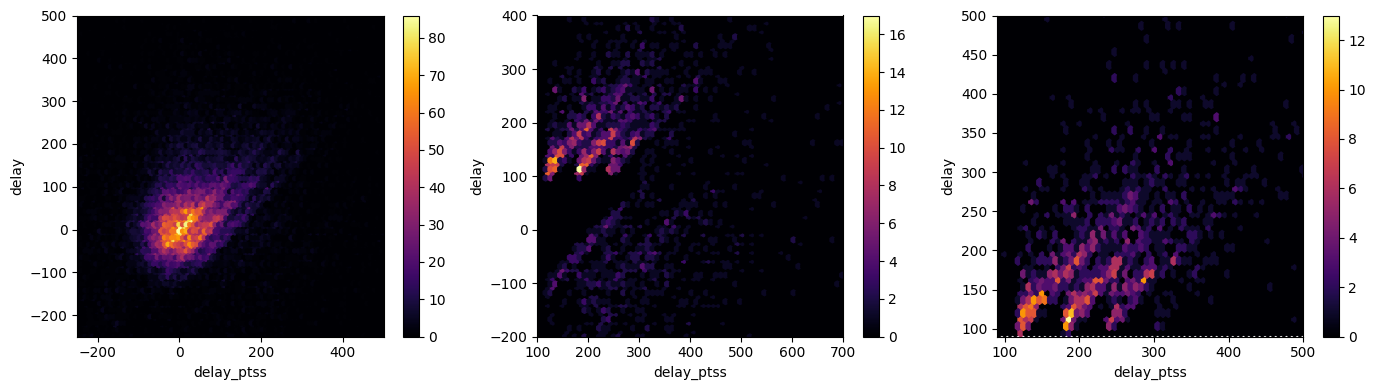

In [8]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, (ax2, ax3, ax4) = plt.subplots(1, 3, figsize=(14, 4))

single_connection.plot(x='delay_ptss', y='delay', kind='hexbin', cmap='inferno', gridsize=800, ax=ax2)
filter_1.plot(x='delay_ptss', y='delay', kind='hexbin', cmap='inferno', gridsize=500, ax=ax3)
filter_2.plot(x='delay_ptss', y='delay', kind='hexbin', cmap='inferno', gridsize=250, ax=ax4)

ax2.set_xlim(-250, 500)
ax2.set_ylim(-250, 500)
# ax2.set_aspect('equal')


ax3.set_xlim(100, 700)
ax3.set_ylim(-200, 400)
# ax3.set_aspect('equal')

ax4.set_xlim(90, 500)
ax4.set_ylim(90, 500)
# ax4.set_aspect('equal')

# plt.show()
plt.tight_layout()
fig.savefig(r'Codebase figures\\Inplace_data_single_station.png', dpi=300)

# Forward

## Find related values

In [9]:
delays_sorted = delays.sort_values(by=['trip_id', 'sched_arrival_time']).copy()

stop_values = delays_sorted['stop'].values
delay_values = delays_sorted['delay'].values
trip_ids = delays_sorted['trip_id'].values
sched_arrivals = delays_sorted['sched_arrival_time'].values
real_arrivals = delays_sorted['real_arrival_time'].values

related_forward = pd.DataFrame({'line': delays_sorted['line_name'].values,
                               'stop': stop_values,
                               'prev_stop': [stop_values[-1], *stop_values[:-1]],
                               'next_stop': [*stop_values[1:], stop_values[0]],
                               'delay': delay_values,
                               'delay_prev_stop': [delay_values[-1], *delay_values[:-1]],
                               'trip_id': trip_ids,
                               'sched_arrival': sched_arrivals,
                               'real_arrival': real_arrivals,
                               'prev_trip_id': [trip_ids[-1], *trip_ids[:-1]],
                               'next_trip_id': [*trip_ids[1:], trip_ids[0]]})

print(f"Total: {len(related_forward):_}")
related_forward = related_forward[(related_forward['trip_id'] == related_forward['prev_trip_id']) | (related_forward['trip_id'] == related_forward['next_trip_id'])]
related_forward.loc[related_forward['trip_id'] != related_forward['prev_trip_id'], ['prev_stop', 'delay_prev_stop']] = None
related_forward = related_forward.drop(columns=['trip_id', 'next_trip_id', 'prev_trip_id'])

print(f"Filtered to only viable: {len(related_forward):_}")
related_forward.head(3)

Total: 3_802_649
Filtered to only viable: 3_802_596


,line,stop,prev_stop,next_stop,delay,delay_prev_stop,sched_arrival,real_arrival
0,SILVER,G05,None,G04,-569.0,NaN,2019-10-14 13:08:00,2019-10-14 12:58:31
1,SILVER,G04,G05,G03,-88.0,-569.0,2019-10-14 13:11:00,2019-10-14 13:09:32
2,SILVER,G03,G04,G02,-106.0,-88.0,2019-10-14 13:14:00,2019-10-14 13:12:14


In [10]:
# Find related values for stops at same station
related_forward = related_forward.sort_values(by=['sched_arrival']).copy()
station_split = {trip_key: data for trip_key, data in related_forward.groupby(['stop', 'next_stop'])}

updated_dfs = []
for key_pair, station_stops in station_split.items():

    station_stops['delay_ptss'] = [None, *station_stops['delay'][:-1]]
    station_stops['real_arrival_prev_train'] = [None, *station_stops['real_arrival'].values[:-1]]
    station_stops['sched_arrival_prev_train'] = [None, *station_stops['sched_arrival'].values[:-1]]

    updated_dfs.append(station_stops)

related_forward = pd.concat(updated_dfs)
print(len(related_forward))
related_forward.head(3)


3802596


C:\Users\lange\AppData\Local\Temp\ipykernel_10384\3703016186.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  related_forward = pd.concat(updated_dfs)
C:\Users\lange\AppData\Local\Temp\ipykernel_10384\3703016186.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  related_forward = pd.concat(updated_dfs)
C:\Users\lange\AppData\Local\Temp\ipykernel_10384\3703016186.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, th

,line,stop,prev_stop,next_stop,delay,delay_prev_stop,sched_arrival,real_arrival,delay_ptss,real_arrival_prev_train,sched_arrival_prev_train
1618603,RED,A01/C01,B01/F01,A02,58.0,102.0,2019-09-14 07:31:00,2019-09-14 07:31:58,NaN,NaT,NaT
1618623,RED,A01/C01,B01/F01,A02,6.0,48.0,2019-09-14 07:42:00,2019-09-14 07:42:06,58.0,2019-09-14 07:31:58,2019-09-14 07:31:00
1618643,RED,A01/C01,B01/F01,A02,-54.0,-25.0,2019-09-14 07:50:00,2019-09-14 07:49:06,6.0,2019-09-14 07:42:06,2019-09-14 07:42:00


##  Filter out in-place

In [11]:
inplace_occcurences = related_forward[(related_forward['real_arrival_prev_train'] >= related_forward['sched_arrival']) & (related_forward['real_arrival'] > related_forward['real_arrival_prev_train'])].copy()
print(f"Amount of found inplace ocurrences: {len(inplace_occcurences):_}")

related_forward_assigned = related_forward[~related_forward.index.isin(inplace_occcurences.index)]
print(f"New amount of forwardly related delays: {len(related_forward_assigned):_}")
related_forward_assigned.head(3)


Amount of found inplace ocurrences: 79_169
New amount of forwardly related delays: 3_723_427


,line,stop,prev_stop,next_stop,delay,delay_prev_stop,sched_arrival,real_arrival,delay_ptss,real_arrival_prev_train,sched_arrival_prev_train
1618603,RED,A01/C01,B01/F01,A02,58.0,102.0,2019-09-14 07:31:00,2019-09-14 07:31:58,NaN,NaT,NaT
1618623,RED,A01/C01,B01/F01,A02,6.0,48.0,2019-09-14 07:42:00,2019-09-14 07:42:06,58.0,2019-09-14 07:31:58,2019-09-14 07:31:00
1618643,RED,A01/C01,B01/F01,A02,-54.0,-25.0,2019-09-14 07:50:00,2019-09-14 07:49:06,6.0,2019-09-14 07:42:06,2019-09-14 07:42:00


## Plot total

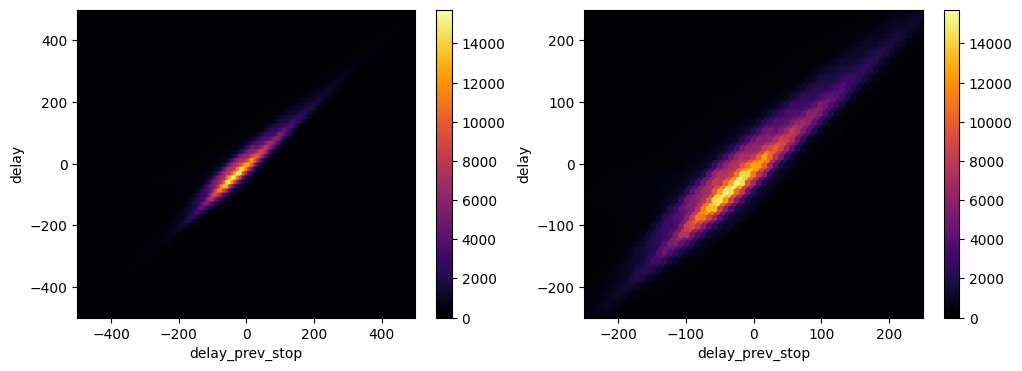

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

related_forward_assigned.plot(x='delay_prev_stop', y='delay', kind='hexbin', cmap='inferno', gridsize=1000, ax=ax1)
related_forward_assigned.plot(x='delay_prev_stop', y='delay', kind='hexbin', cmap='inferno', gridsize=1000, ax=ax2)

ax1.set_xlim(-500, 500)
ax1.set_ylim(-500, 500)

ax2.set_xlim(-250, 250)
ax2.set_ylim(-250, 250)

plt.show()

## Plot single station

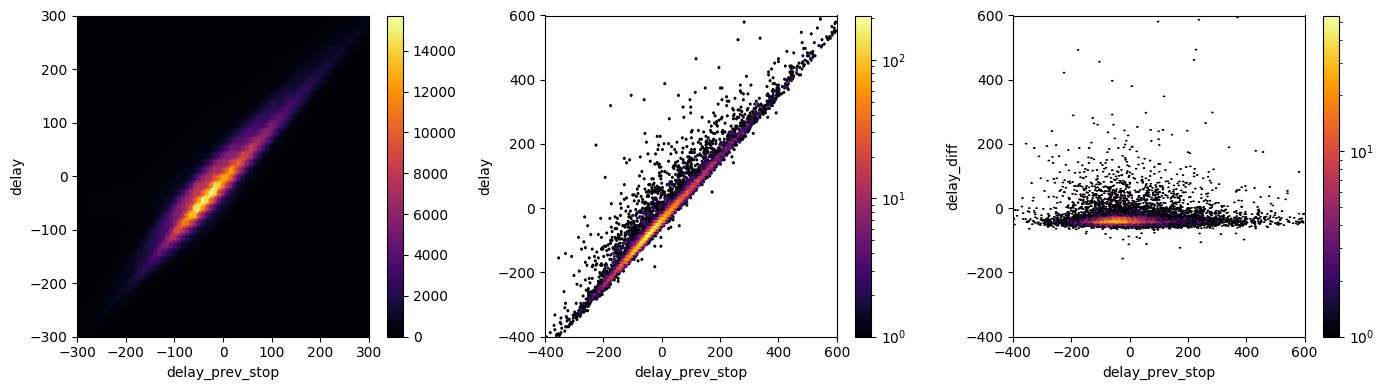

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))

related_forward_assigned.plot(x='delay_prev_stop', y='delay', kind='hexbin', cmap='inferno', gridsize=1000, ax=ax1)

single_connection = related_forward_assigned[(related_forward_assigned['stop'] == 'A10') & (related_forward_assigned['next_stop'] == 'A11')].copy()
single_connection.plot(x='delay_prev_stop', y='delay', kind='hexbin', cmap='inferno', bins='log', gridsize=800, ax=ax2)

linear_removed = single_connection.copy()
linear_removed['delay_diff'] = linear_removed['delay'] - linear_removed['delay_prev_stop']
linear_removed.plot(x='delay_prev_stop', y='delay_diff', kind='hexbin', cmap='inferno', bins='log', gridsize=1000, ax=ax3)

ax1.set_xlim(-300, 300)
ax1.set_ylim(-300, 300)

ax2.set_xlim(-400, 600)
ax2.set_ylim(-400, 600)

ax3.set_xlim(-400, 600)
ax3.set_ylim(-400, 600)

plt.tight_layout()
fig.savefig(r'Codebase figures\\Forward_heatmaps.png', dpi=300)

plt.show()